In [531]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pypsa

%matplotlib inline

In [532]:
# We need a gas generator that represents dispatchable generation

# Define a simple but realistic demand curve

# Add solar PV generation

# Create EVs as a storage unit. It has a load during commute and is connected during the day and evening


In [533]:
# use 24 hour period for consideration
index = pd.date_range("2016-01-01 00:00", "2016-01-01 23:00", freq="h")

demand = pd.Series([
    21, 20, 20, 19,
    19, 20, 21, 23,
    25, 26, 28, 29,
    29, 29, 29, 29,
    29, 28, 27, 26,
    25, 24, 23, 22
    ], index)

solar_pv = pd.Series(
    [0] * 7 + [1] +
    [6] + [10] + [12] + [14] +
    [15] + [15] + [14] + [12] +
    [10] + [6] + [1] +
    [0] * 5,
    index
)

array([<Axes: >, <Axes: >], dtype=object)

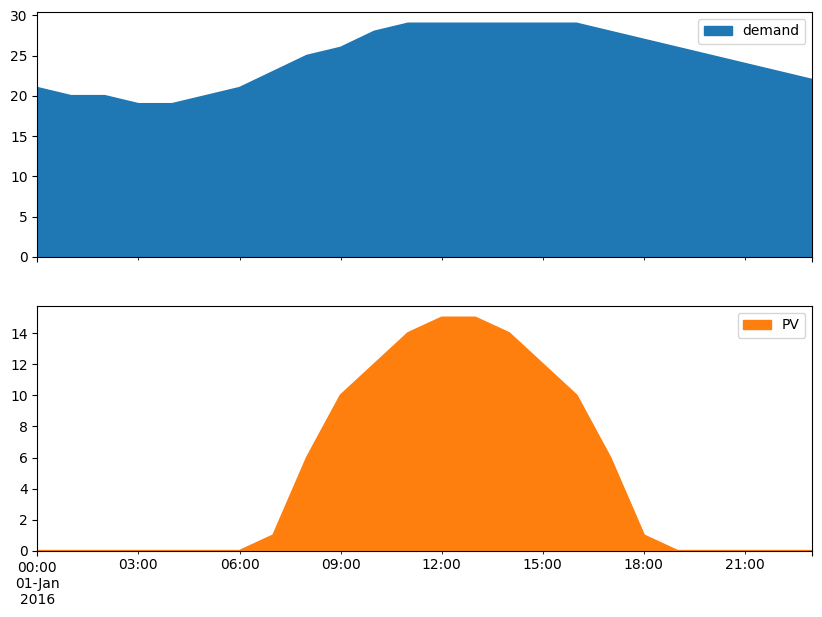

In [534]:
df = pd.concat({"demand": demand, "PV": solar_pv}, axis=1)
df.plot.area(subplots=True, figsize=(10, 7))

In [535]:
network = pypsa.Network()
network.set_snapshots(index)

network.add("Bus", "grid", carrier="AC")
network.add("Generator",
    "Gas",
    bus="grid",
    p_nom_extendable=True,
    p_max_pu=40,
    marginal_cost=120)

network.add("Generator",
    "Coal",
    bus="grid",
    # p_nom_extendable=True,
    p_nom=1,
    p_max_pu=15,
    marginal_cost=80)

network.add("Generator", "PV", bus="grid", p_nom=1, p_max_pu=solar_pv, marginal_cost=20)

network.add("Load", "demand", bus="grid", p_set=demand)


In [536]:
# bev_usage = pd.Series([0.0] * 7 + [9.0] * 2 + [0.0] * 8 + [9.0] * 2 + [0.0] * 5, index)

network.add("Bus", "home", carrier="AC")

network.add("Bus", "battery", carrier="AC")

network.add("Link", "street", p_nom=1, bus0="grid", bus1="home", p_min_pu=-1, p_max_pu=1)

bev_hourly_load = 0.009
bev_usage = pd.Series([0.0] * 7 + [bev_hourly_load] * 2 + [0.0] * 8 + [bev_hourly_load] * 2 + [0.0] * 5, index)
network.add("Load", "driving", bus="battery", p_set=bev_usage)

charger_p_max_pu = pd.Series([1.0] * 7 + [0.0] * 2 + [0.0] * 8 + [0.0] * 2 + [1.0] * 5, index)
charger_p_min_pu = pd.Series([-1.0] * 7 + [0.0] * 2 + [0.0] * 8 + [0.0] * 2 + [-1.0] * 5, index)
network.add(
    "Link",
    "charger",
    bus0="home",
    bus1="battery",
    p_nom=120,  # super-charger with 120 kW
    p_max_pu=charger_p_max_pu,
    p_min_pu=charger_p_min_pu,
    # p_min_pu=-100,
    efficiency=0.9,
)

battery_e_min_pu = pd.Series([0] * 23 + [1], index)
network.add("Store", "battery storage", bus="battery", e_cyclic=False, e_initial=0.1, e_nom=0.1, e_min_pu=battery_e_min_pu)

In [537]:
network.optimize()


Index(['grid', 'home', 'battery'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='Store')
Index(['street', 'charger'], dtype='object', name='Link')
Index(['grid', 'home', 'battery'], dtype='object', name='Bus')
Index(['battery storage'], dtype='object', name='Store')
Index(['street', 'charger'], dtype='object', name='Link')
INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.02s
INFO:linopy.solvers:Log file at /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/highs.log
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 169 primals, 385 duals
Objective: 4.50e+04
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper, Generator-ext-p-lower, Generator-ext-p-upper, Link-fix-p-lower, Link-fix-p-upper, Store-fix-e-lower, Store-fix-e-upper, Store-energy_balance were no

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [9e-01, 4e+01]
  Cost   [2e+01, 1e+02]
  Bound  [0e+00, 0e+00]
  RHS    [9e-03, 1e+02]
Presolving model
34 rows, 57 cols, 78 nonzeros  0s
2 rows, 6 cols, 6 nonzeros  0s
Presolve : Reductions: rows 2(-383); columns 6(-163); elements 6(-570)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     4.2164800000e+04 Pr: 2(58) 0s
          2     4.5004800000e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 2
Objective value     :  4.5004800000e+04
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/0d/q51cf8693zj50wd4hy84k0zh0000gn/T/linopy-solve-dq5vodkd.sol


('ok', 'optimal')

In [538]:
# network.generators_t.p

In [539]:
# network.stores_t.p

<Axes: xlabel='snapshot'>

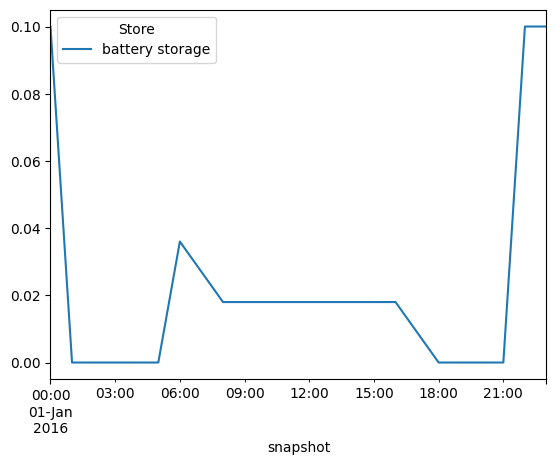

In [553]:
fig, ax = plt.subplots()
network.stores_t.e.plot(ax=ax, label="SoC")
# network.stores_t.p.plot(ax=ax, label="Output")

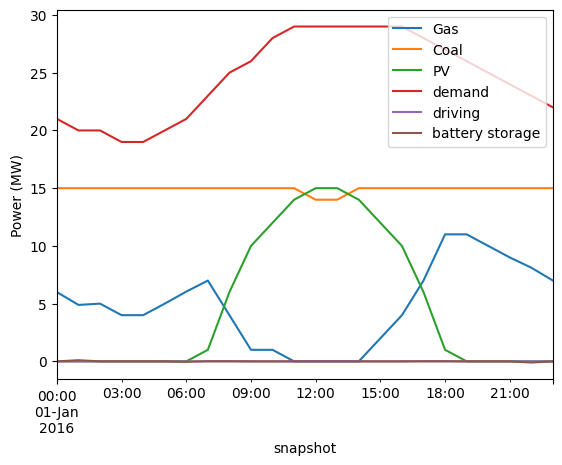

In [541]:
# network.generators_t.p.plot.area(figsize=(9, 4))
# plt.tight_layout()

fig, ax = plt.subplots()

(network.generators_t.p).plot(ax=ax)
network.loads_t.p_set.plot(ax=ax)
network.stores_t.p.plot(ax=ax)

ax.set_ylabel("Power (MW)")
ax.get_legend().set_title("")

In [542]:
# consumption pattern of BEV
bev_usage = pd.Series([0.0] * 7 + [9.0] * 2 + [0.0] * 8 + [9.0] * 2 + [0.0] * 5, index)

# solar PV panel generation per unit of capacity
pv_pu = pd.Series(
    [0.0] * 7
    + [0.2, 0.4, 0.6, 0.75, 0.85, 0.9, 0.85, 0.75, 0.6, 0.4, 0.2, 0.1]
    + [0.0] * 5,
    index,
)

# availability of charging - i.e. only when parked at office
charger_p_max_pu = pd.Series(0, index=index)
charger_p_max_pu["2016-01-01 09:00":"2016-01-01 16:00"] = 1.0

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

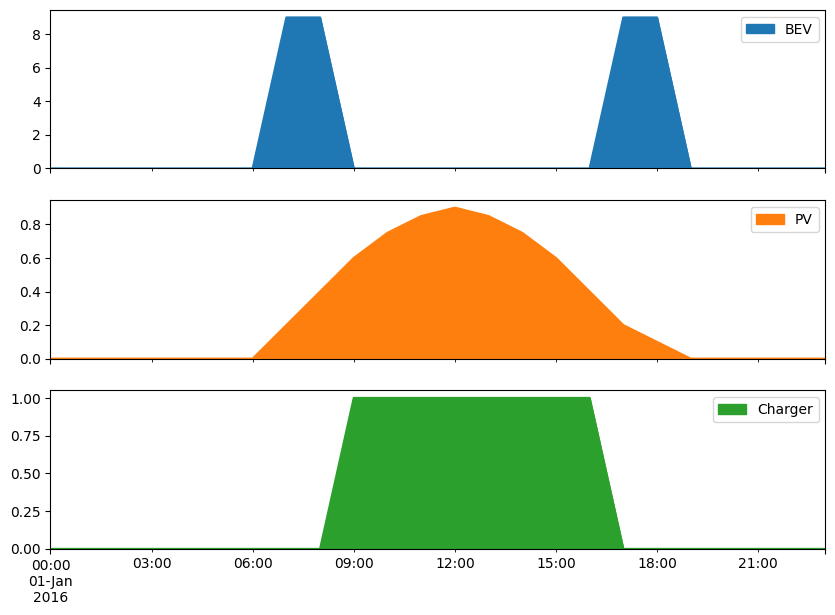

In [543]:
df = pd.concat({"BEV": bev_usage, "PV": pv_pu, "Charger": charger_p_max_pu}, axis=1)
df.plot.area(subplots=True, figsize=(10, 7))


In [544]:
# df.plot.area(subplots=True, figsize=(10, 7))
# plt.tight_layout()

In [545]:
# network = pypsa.Network()
# network.set_snapshots(index)

# network.add("Bus", "place of work", carrier="AC")

# network.add("Bus", "battery", carrier="Li-ion")

# network.add(
#     "Generator",
#     "PV panel",
#     bus="place of work",
#     p_nom_extendable=True,
#     p_max_pu=pv_pu,
#     capital_cost=1000.0,
# )

# network.add("Load", "driving", bus="battery", p_set=bev_usage)

# network.add(
#     "Link",
#     "charger",
#     bus0="place of work",
#     bus1="battery",
#     p_nom=120,  # super-charger with 120 kW
#     p_max_pu=charger_p_max_pu,
#     efficiency=0.9,
# )


# network.add("Store", "battery storage", bus="battery", e_cyclic=True, e_nom=100.0)

In [546]:
# network.optimize(solver_name="highs")
# print("Objective:", network.objective)

In [547]:
# network.generators.p_nom_opt["PV panel"]

In [548]:
# network.generators_t.p.plot.area(figsize=(9, 4))
# plt.tight_layout()

In [549]:
# df = pd.DataFrame(
#     {attr: network.stores_t[attr]["battery storage"] for attr in ["p", "e"]}
# )
# df.plot(grid=True, figsize=(10, 5))
# plt.legend(labels=["Energy output", "State of charge"])
# plt.tight_layout()

In [550]:

# (
#     network.generators_t.p.loc[:, "PV panel"].sum()
#     - network.loads_t.p.loc[:, "driving"].sum()
# )

In [551]:
# network.links_t.p0.plot.area(figsize=(9, 5))
# plt.tight_layout()